# Skin Cancer Classification Using Convolutional Neural Network

In [1]:
train_data_directory = 'train'
test_data_directory = 'test'

In [2]:
import os # operating system
import re # regular expression
import cv2 # open cv
import time
import numpy as np
from os import listdir
from os.path import isfile, join
from random import randrange # random range
import matplotlib.pyplot as plt
import tensorflow as tf

load_model = tf.keras.models.load_model
image = tf.keras.preprocessing.image
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

In [3]:
# initiate data preprocessing tools

# This step processes the images into a format that
# 1. makes the data readable to the model
# 2. provides more training material for the model to train from
# the `training_data_processor` below scales the data so that it can be
# a model input, but also takes each image and augments it so that
# the model can learn from multiple variations of the same image.
# it flips it horizontally, rotates it, shifts it, and more so that 
# the model learns from the soil photo rather than the orientation size
training_data_processor  = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
)
# for the testing images, we don't need to create multiple variatinos
test_data_processor = ImageDataGenerator(rescale=1./255)


# load data into python

training_data = training_data_processor.flow_from_directory(
    train_data_directory,
    target_size = (600, 450), # pixels
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (600, 450),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 10015 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


## Model Building

In [6]:
# choose model parameters
num_conv_layers = 3
num_dense_layers = 2
layer_size = 29 # limit the layer size as we dont want to over fit the model
num_training_epochs = 20
MODEL_NAME = 'skin_cancer_classifier'

CLASSES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [7]:
# initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convulutional layer
model.add(Conv2D(layer_size, (3,3), input_shape=(600, 450, 3)))
model.add(Activation('relu')) # rectified linear unit
model.add(MaxPooling2D(pool_size=(2,2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# output layer
model.add(Dense(len(CLASSES)))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# use the data already loaded to train/tune the model
model.fit(
    training_data, 
    epochs = num_training_epochs, 
    validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/20
313/313 [==============================] - 1809s 6s/step - loss: 1.0260 - accuracy: 0.6628 - val_loss: 2.9059 - val_accuracy: 0.1486
Epoch 2/20
313/313 [==============================] - 1778s 6s/step - loss: 0.9178 - accuracy: 0.6684 - val_loss: 2.4447 - val_accuracy: 0.1600
Epoch 3/20
313/313 [==============================] - 1617s 5s/step - loss: 0.8632 - accuracy: 0.6764 - val_loss: 2.1907 - val_accuracy: 0.1971
Epoch 4/20
313/313 [==============================] - 1563s 5s/step - loss: 0.8435 - accuracy: 0.6788 - val_loss: 2.1112 - val_accuracy: 0.1971
Epoch 5/20
313/313 [==============================] - 1612s 5s/step - loss: 0.8246 - accuracy: 0.6884 - val_loss: 1.7665 - val_accuracy: 0.2714
Epoch 6/20
313/313 [==============================] - 1655s 5s/step - loss: 0.8086 - accuracy: 0.6948 - val_loss: 1.7122 - val_accuracy: 0.3543
Epoch 7/20
313/313 [==============================] - 1577s 5s/step - loss: 0.8090 - accuracy: 0.7002 - val_loss: 1.5415 - val_accuracy:

In [23]:
def classify(image_fp):
    im = cv2.imread(image_fp) # load the image from the given file path (image_fp)
    plt.imshow(im[:,:,[2,1,0]]) # swap the colors because open-cv swaps the rgb colors
    img = image.load_img(image_fp, target_size = (600, 450))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = CLASSES # possible output values
    from tensorflow import keras
    model = keras.models.load_model('skin_cancer_classifier.h5')
    predicted_value = model.predict(img_batch)
    # predicted_value = class_[model.predict(img_batch).argmax()]
    # true_value = re.search(r'(clay)|(gravel)|(humus)|(peat)|(sand)', image_fp)[0]
    out  = f"""
      akiec: {predicted_value[0][0]:.5f}
        bcc: {predicted_value[0][1]:.5f}
        bkl: {predicted_value[0][2]:.5f}
         df: {predicted_value[0][3]:.5f}
        mel: {predicted_value[0][4]:.5f}
         nv: {predicted_value[0][5]:.5f}
        vsc: {predicted_value[0][6]:.5f}

     Result: {(predicted_value[0][predicted_value.argmax()] * 100):.2f}% {class_[predicted_value.argmax()]}
    """
    return out

1/1 [==============================] - 0s 85ms/step

      akiec: 0.01045
        bcc: 0.01954
        bkl: 0.17236
         df: 0.00681
        mel: 0.20560
         nv: 0.58513
        vsc: 0.00010

     Result: 58.51% nv
    


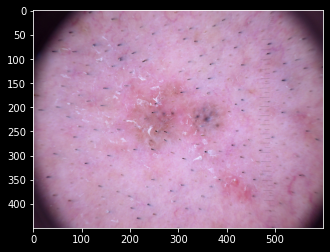

In [26]:
test_image_file_path = test_data_directory + '/bcc/ISIC_0024436.jpg'
test_prediction = classify(test_image_file_path)

print(test_prediction)